In [33]:
# Importing Required lib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import r2_score

In [3]:
# Importing data with dates
air_pollution = pd.read_csv('air_pollution.csv', parse_dates=['date'])
air_pollution.set_index('date', inplace=True)
 
split_date = '2014-01-01'
df_training = air_pollution.loc[air_pollution.index <= split_date]
df_test = air_pollution.loc[air_pollution.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")


1461 days of training data 
 364 days of testing data 


Multivariate time series forecasting¶

In [4]:
# ADD time features to our model
def create_time_features(df, target=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['sin_day'] = np.sin(df['dayofyear'])
    df['cos_day'] = np.cos(df['dayofyear'])
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    X = df.drop(['date'], axis=1)
    if target:
        y = df[target]
        X = X.drop([target], axis=1)
        return X, y

    return X

In [5]:
X_train_df, y_train = create_time_features(
df_training, target='pollution_today')
X_test_df, y_test = create_time_features(df_test, target='pollution_today')
scaler = StandardScaler()
scaler.fit(X_train_df)  # No cheating, never scale on the training+test!
X_train = scaler.transform(X_train_df)
X_test = scaler.transform(X_test_df)

X_train_df = pd.DataFrame(X_train, columns=X_train_df.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test_df.columns)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [7]:
# For our dl model we will create windows of data that will be feeded into the datasets, for each timestemp T we will append the data from T-7 to T to the Xdata with target Y(t)
BATCH_SIZE = 64
BUFFER_SIZE = 100
WINDOW_LENGTH = 24


def window_data(X, Y, window=7):
    x = []
    y = []
    for i in range(window-1, len(X)):
        x.append(X[i-window+1:i+1])
        y.append(Y[i])
    return np.array(x), np.array(y)


# Since we are doing sliding, we need to join the datasets again of train and test
X_w = np.concatenate((X_train, X_test))
y_w = np.concatenate((y_train, y_test))

X_w, y_w = window_data(X_w, y_w, window=WINDOW_LENGTH)
X_train_w = X_w[:-len(X_test)]
y_train_w = y_w[:-len(X_test)]
X_test_w = X_w[-len(X_test):]
y_test_w = y_w[-len(X_test):]

# Check we will have same test set as in the previous models, make sure we didnt screw up on the windowing
print(f"Test set equal: {np.array_equal(y_test_w,y_test)}")

train_data = tf.data.Dataset.from_tensor_slices((X_train_w, y_train_w))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((X_test_w, y_test_w))
val_data = val_data.batch(BATCH_SIZE).repeat()

Test set equal: True


In [46]:
dropout = 0.0
model = Sequential()

model.add(LSTM(512, input_shape=X_train_w.shape[-2:], dropout=dropout))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation ='relu'))
model.add(Dense(1))
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

EVALUATION_INTERVAL = 200
EPOCHS = 20

model_history = simple_lstm_model.fit(train_data, epochs=EPOCHS,
                                      steps_per_epoch=EVALUATION_INTERVAL,
                                      validation_data=val_data, validation_steps=50) 

y_pred = simple_lstm_model.predict(X_test_w).reshape(1, -1)[0]

from sklearn.metrics import  r2_score
print(r2_score(y_test,y_pred))

Epoch 1/20
200/200 [==============================] - 5s 14ms/step - loss: 58.1269 - val_loss: 52.6936
Epoch 2/20
200/200 [==============================] - 2s 11ms/step - loss: 41.9373 - val_loss: 39.9785
Epoch 3/20
200/200 [==============================] - 2s 11ms/step - loss: 33.0162 - val_loss: 36.7217
Epoch 4/20
200/200 [==============================] - 2s 11ms/step - loss: 28.6718 - val_loss: 34.4737
Epoch 5/20
200/200 [==============================] - 2s 11ms/step - loss: 27.5334 - val_loss: 35.3934
Epoch 6/20
200/200 [==============================] - 2s 11ms/step - loss: 25.8498 - val_loss: 42.3599
Epoch 7/20
200/200 [==============================] - 2s 11ms/step - loss: 24.3029 - val_loss: 36.0332
Epoch 8/20
200/200 [==============================] - 2s 11ms/step - loss: 21.7872 - val_loss: 40.9586
Epoch 9/20
200/200 [==============================] - 2s 11ms/step - loss: 21.6566 - val_loss: 32.1799
Epoch 10/20
200/200 [==============================] - 2s 11ms/step - los

In [11]:
# Univariate with only air polloution features

In [4]:
df = air_pollution['pollution_today']
df

date
2010-01-02    145.958333
2010-01-03     78.833333
2010-01-04     31.333333
2010-01-05     42.458333
2010-01-06     56.416667
                 ...    
2014-12-27    238.666667
2014-12-28    197.375000
2014-12-29    159.000000
2014-12-30     46.083333
2014-12-31     10.041667
Name: pollution_today, Length: 1825, dtype: float64

In [23]:
# Scaling the Data befor feeding into lstm

x_train = df.iloc[:1400]
x_test = df.iloc[1400:]

x_train = x_train.values.reshape(-1,1)
x_test = x_test.values.reshape(-1,1)


scaler_df = StandardScaler()
scaler_df.fit(x_train)
train  = scaler_df.transform(x_train)
test = scaler_df.transform(x_test)

In [26]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [29]:
n_inputs = 5
n_features = 1
generator = TimeseriesGenerator(train,train  ,length = n_inputs,batch_size = 1 )

In [38]:
lstm_uni = Sequential()

lstm_uni.add(LSTM(128, input_shape = (n_inputs, n_features), activation = 'relu'))
lstm_uni.add(Dense(64, activation = 'relu'))
lstm_uni.add(Dense(32, activation = 'relu'))
lstm_uni.add(Dense(1))

lstm_uni.compile(optimizer = 'adam', loss = 'mse')

In [40]:
lstm_uni.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               66560     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 76,929
Trainable params: 76,929
Non-trainable params: 0
_________________________________________________________________


In [43]:
lstm_uni.fit(generator,epochs = 20)

Epoch 1/20
1395/1395 [==============================] - 33s 20ms/step - loss: 0.7753
Epoch 2/20
1395/1395 [==============================] - 28s 20ms/step - loss: 0.6879
Epoch 3/20
1395/1395 [==============================] - 28s 20ms/step - loss: 0.6928
Epoch 4/20
1395/1395 [==============================] - 27s 19ms/step - loss: 0.6806
Epoch 5/20
1395/1395 [==============================] - 27s 20ms/step - loss: 0.6700
Epoch 6/20
1395/1395 [==============================] - 27s 19ms/step - loss: 0.6639
Epoch 7/20
1395/1395 [==============================] - 28s 20ms/step - loss: 0.6714
Epoch 8/20
1395/1395 [==============================] - 29s 21ms/step - loss: 0.6711
Epoch 9/20
1395/1395 [==============================] - 28s 20ms/step - loss: 0.6544
Epoch 10/20
1395/1395 [==============================] - 28s 20ms/step - loss: 0.6531
Epoch 11/20
1395/1395 [==============================] - 27s 19ms/step - loss: 0.6514
Epoch 12/20
1395/1395 [==============================] - 27s 20

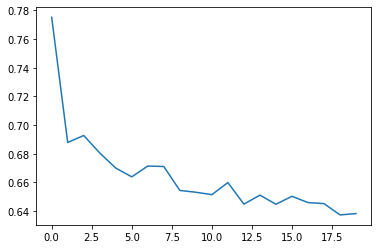

In [44]:
loss_per_epoch = lstm_uni.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [45]:
y_pred = lstm_uni.predict(test)

In [47]:
from sklearn.metrics import r2_score
print(r2_score(test, y_pred))

0.6572023645637792


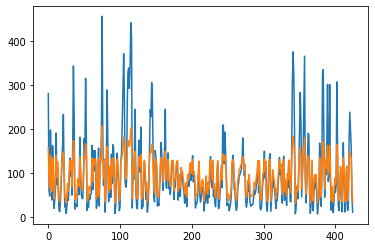

In [70]:
y_pred_inv = scaler_df.inverse_transform(y_pred)

plt.plot(figsize=(14,5))
# plt.figure.figsize = (25,4)
plt.plot(x_test)
plt.plot(y_pred_inv)

In [51]:
test_predictions = []

first_eval_batch = train[-n_inputs:]
current_batch = first_eval_batch.reshape((1, n_inputs, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = lstm_uni.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [53]:
test_predictions

[array([0.9155004], dtype=float32),
 array([0.04160841], dtype=float32),
 array([-0.02575675], dtype=float32),
 array([0.08791399], dtype=float32),
 array([0.21539193], dtype=float32),
 array([0.33521283], dtype=float32),
 array([0.39488465], dtype=float32),
 array([0.41777703], dtype=float32),
 array([0.4154026], dtype=float32),
 array([0.41437727], dtype=float32),
 array([0.41555405], dtype=float32),
 array([0.41601032], dtype=float32),
 array([0.41614366], dtype=float32),
 array([0.41617668], dtype=float32),
 array([0.4161933], dtype=float32),
 array([0.41620368], dtype=float32),
 array([0.41620767], dtype=float32),
 array([0.41620922], dtype=float32),
 array([0.41620982], dtype=float32),
 array([0.4162101], dtype=float32),
 array([0.41621017], dtype=float32),
 array([0.41621023], dtype=float32),
 array([0.41621026], dtype=float32),
 array([0.41621026], dtype=float32),
 array([0.41621026], dtype=float32),
 array([0.41621026], dtype=float32),
 array([0.41621026], dtype=float32),
 arr

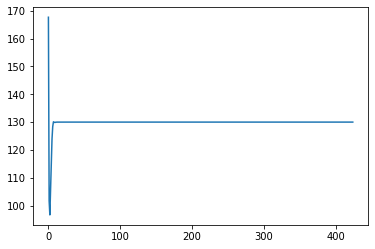

In [71]:
true_predictions = scaler_df.inverse_transform(test_predictions)
plt.plot(true_predictions)
# test.plot(figsize=(14,5))

In [57]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Production'],test['Predictions']))
print(rmse)

IndexError: ignored